In [ ]:
import time, datetime, collections
import requests, numpy as np

In [ ]:
# This is grade A lazy attempt to stop github key parsers - need to implement env stuff properly...
gapikey1 = 'asdasd_AIzaSyA8ZTz_'
gapikey2 = 'dsfsdf_o3VhApo4CoehKa6m7_cFLKKBnXt'
gapikey = (gapikey1+gapikey2[::-1])[7:-7]

In [ ]:
# Make this notebook wiiiiiiiiide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Some functions first
def computeTravelTimes(origin, destination, date, resolution=20, options=None):
    """Computes travel duration for the given trip/date, with resolution specified"""
    
    # First, need to create a list of times for the selected week (python 3 - can multiply timedeltas weeee!)
    # Note that we create a naive datetime, which means system timezone will be used for utc conversion later
    initial_datetime = datetime.datetime.combine(date, datetime.time(0,0,0))   
    time_offsets = [datetime.timedelta(minutes=resolution)*i for i in range(0,24*60//resolution)]
    final_dts = [initial_datetime + x for x in time_offsets]
    
    # Now just query all the datapoints
    results = collections.OrderedDict()
    print('Computing data for {} ({} points)'.format(date.strftime("%d/%m/%y"),len(final_dts)))
    for i, dt in enumerate(final_dts):
        dt_key = dt.strftime("%d/%m/%y %H:%M")
        results[dt] = {}
        if options and 'notolls' in options:
            gresponse = getGMapsRespDriving(origin, destination, dt, avoid='tolls')
        else:
            gresponse = getGMapsRespDriving(origin, destination, dt)
        #time.sleep(0.1)
        #print(gresponse)
        if gresponse['status'] == 'OK': 
            # Access the desired data
            elements = gresponse['rows'][0]['elements']
            assert len(elements) == 1
            entry = elements[0]
            
            # After ensuring we only got 1 result, parse it
            if (entry['status'] == 'OK'):
                results[dt]['roaddist'] = entry['distance']['value']
                results[dt]['time'] = entry['duration']['value']
                results[dt]['time_traffic'] = entry['duration_in_traffic']['value']                                    
                #print('GMatrix response: {:2d}|{}|{}|{}'.format(i,dt,results[dt]['time'],results[dt]['time_traffic']))
            else:
                print('{}|{} - element status is not OK!!!'.format(i,dt))
        else:
            print('{}|{} - response status is not OK!!!'.format(i,dt))
    return results
        
def getGMapsRespDriving(origin, destination, dep_time, mode='driving', avoid=None, traffic_model='best_guess', **kwargs):   
    """Wrapper around query to GMaps API url - returns json dictionary of the response"""
          
    urlparams = {'units':'imperial','origins':origin,'destinations':destination,'key':gapikey,'mode':mode,
                'departure_time':int(dep_time.timestamp()),'mode':mode,'traffic_model':traffic_model,**kwargs}    
    if avoid: urlparams['avoid'] = avoid    
        
    resp = requests.get('https://maps.googleapis.com/maps/api/distancematrix/json',params=urlparams)
    rj = resp.json()
    #print(rj)
    return rj

In [5]:
# Main code - constants first
origin = '1363 E 50th St, Chicago, IL, 60615, USA' # Close to where you live (plz no dox)
dest = 'Pine St, Batavia, IL, 60510, USA' # Fermilab
date_start = datetime.date(2018, 1, 15) # typically want a monday for first day
res = 20

# Get dates for whole work week
dates = [date_start] + [date_start+datetime.timedelta(days=i) for i in range(1,5)]   
print('Dates: ',dates)
    
results = collections.OrderedDict()

# Times with/without tolls going forward
for d in dates:
    results[d] = {}
    results[d]['fwd_tolls'] = computeTravelTimes(origin, dest, d, resolution=res)
    results[d]['fwd_notolls'] = computeTravelTimes(origin, dest, d, resolution=res, options='notolls')      

In [6]:
# Import interactive mpl version
%matplotlib notebook
import matplotlib.dates as mdates, matplotlib.pyplot as plt, seaborn as sns

<IPython.core.display.Javascript object>


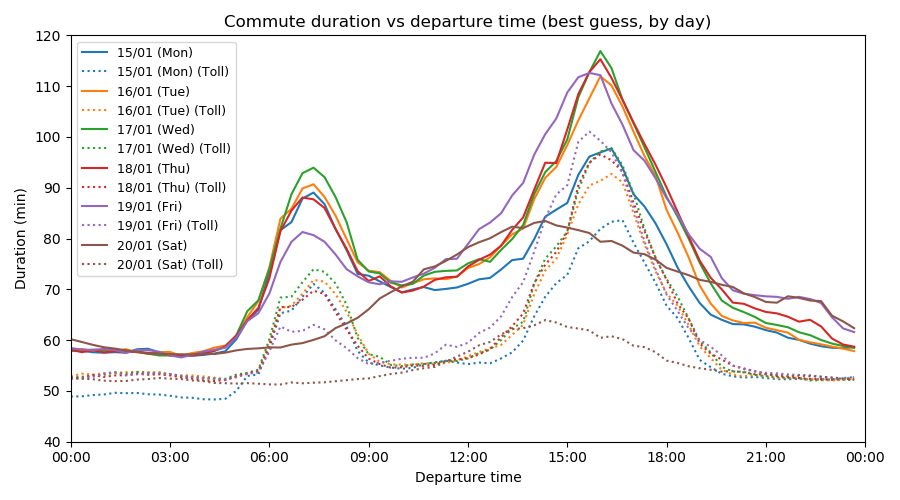

In [10]:
# This is the money plot
fig, ax = plt.subplots(figsize=(9, 5))
key1 = 'fwd_notolls'
key2 = 'fwd_tolls'

for i, (date, data) in enumerate(results.items()):
    # bring all dates to same day because can't easily plot times directly
    xdata = [dt.replace(year=2018, month=1, day=1) for dt in data[key1].keys()]
    ydata1 = [trip['time_traffic']/60 for trip in data[key1].values()]
    ydata2 = [trip['time_traffic']/60 for trip in data[key2].values()]
    plt.plot(xdata,ydata1,label=date.strftime("%d/%m (%a)"),color='C'+str(i))
    plt.plot(xdata,ydata2,label=date.strftime("%d/%m (%a)") + " (Toll)",color='C'+str(i),linestyle=':')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Commute duration vs departure time (best guess, by day)')
plt.xlabel('Departure time')
plt.ylabel('Duration (min)')
plt.xlim([datetime.datetime(2018,1,1,0,0,0),datetime.datetime(2018,1,2,0,0,0)])
plt.ylim([40,120])
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


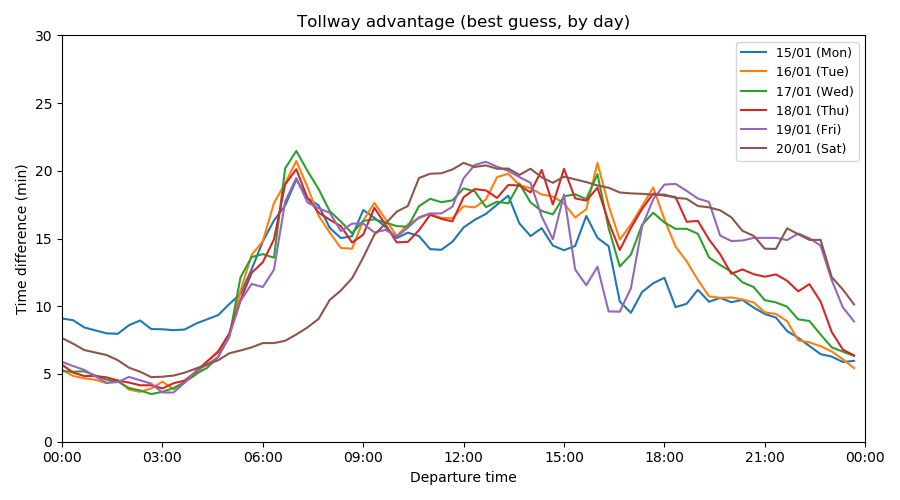

In [26]:
# How much do you gain by using tollways?
fig, ax = plt.subplots(figsize=(9, 5))
key1 = 'fwd_notolls'
key2 = 'fwd_tolls'

for i, (date, data) in enumerate(results.items()):
    # bring all dates to same day because can't easily plot times directly
    xdata = [dt.replace(year=2018, month=1, day=1) for dt in data[key1].keys()]
    ydata1 = np.array([trip['time_traffic']/60 for trip in data[key1].values()])
    ydata2 = np.array([trip['time_traffic']/60 for trip in data[key2].values()])
    ydata3 = ydata1 - ydata2
    plt.plot(xdata,ydata3,label=date.strftime("%d/%m (%a)"),color='C'+str(i))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Tollway advantage (best guess, by day)')
plt.xlabel('Departure time')
plt.ylabel('Time difference (min)')
plt.xlim([datetime.datetime(2018,1,1,0,0,0),datetime.datetime(2018,1,2,0,0,0)])
plt.ylim([0,30])
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


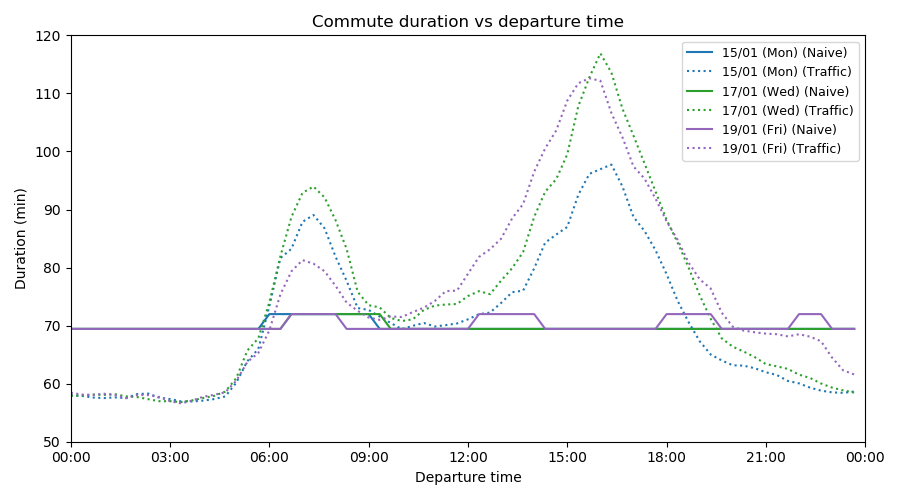

In [16]:
# Comparing naive and traffic times -> naive ones are useless...
fig, ax = plt.subplots(figsize=(9, 5))
key1 = 'fwd_notolls'

for i, (date, data) in enumerate(results.items()):
    if i%2 == 0:
        xdata = [dt.replace(year=2018, month=1, day=1) for dt in data[key1].keys()]
        ydata1 = [trip['time']/60 for trip in data[key1].values()]
        ydata2 = [trip['time_traffic']/60 for trip in data[key1].values()]
        plt.plot(xdata,ydata1,label=date.strftime("%d/%m (%a) (Naive)"),color='C'+str(i))
        plt.plot(xdata,ydata2,label=date.strftime("%d/%m (%a) (Traffic)"),color='C'+str(i),linestyle=':')
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Commute duration vs departure time')
plt.xlabel('Departure time')
plt.ylabel('Duration (min)')
plt.xlim([datetime.datetime(2018,1,1,0,0,0),datetime.datetime(2018,1,2,0,0,0)])
plt.ylim([50,120])
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()